### Goal

This notebook has the full pipeline to parse Sentinel 5p data from AWS s3.


* Partition will be by **time**
* `.parquet` format

### Install steps

You may need to do the following pip installs

1. `!pip install xarray`
2. `!pip install geopandas`
3. `!pip install shapely`
4. `!pip install netCDF4`



In [2]:
#!pip install xarray
#!pip install geopandas
#!pip install shapely
#!pip install netCDF4

### TODOS:
* Check speed on a couple different machines

In [3]:
import traceback
import sys
import subprocess
import pickle
import os
import glob

from collections import Counter
try:

    from matplotlib import pyplot as plt #viz
    import matplotlib.colors as colors #colors for viz
    import xarray as xr #process NetCDF
    import numpy as np
    import pandas as pd #data manipulation
    import matplotlib.gridspec as gridspec #create subplot
    from glob import iglob #data access in file manager
    from os.path import join 
    from functools import reduce #string manipulation
    import itertools #dict manipulation
    import matplotlib.patches as mpatches
    
    from datetime import datetime, timedelta
    import time
    import pytz
    
    
    #GeoPandas
    import geopandas as gpd
    from shapely.geometry import Point
    from shapely.geometry.polygon import Polygon
    
except ModuleNotFoundError:

    print('\nModule import error', '\n')
    print(traceback.format_exc())

else:
    print('\nAll libraries proeprly loaded!!', '\n')

### HELPER FUNCTIONS
def getHumanTime(seconds):
    '''Make seconds human readable'''
    if seconds <= 1.0:
        return '00:00:01'
    
    seconds = int(seconds)
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return '{:d}:{:02d}:{:02d}'.format(h, m, s) # Python 3


def print_write(content, f_object, should_print=True):
    '''This function will both, and write the content to a local file'''
    if should_print: print(content)
    if f_object:
        f_object.write(content)
        f_object.write('\n')





All libraries proeprly loaded!! 



### Load in CA GeoJSON --> Polygon
* Check point in Polygon - https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon
* Link to GeoJSON - https://github.com/ropensci/geojsonio/blob/master/inst/examples/california.geojson

We will use this to strictly filter data only for California

                                            geometry
0  POLYGON ((48.97705 56.40782, 49.06494 55.07837...


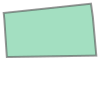

In [4]:
ca_geo_path = "/root/methane/data_processing/resources/testsite2.geojson"
ca_geo_file = open(ca_geo_path)
ca_gpd = gpd.read_file(ca_geo_file)
cali_polygon = ca_gpd['geometry'][0]
print(ca_gpd)
cali_polygon

### Sanity Check 

Do a quick check to ensure that the point checking is working 

In [5]:
def inCalifornia(lat,lon):
    '''Given lat, lon. Return Boolean if in California'''
    point = Point(lon, lat)
    return cali_polygon.contains(point)

#Point in Arizona
az_y= 32.866806
az_x = -114.35925
print("In California") if inCalifornia(az_y, az_x) else print("NOT in California")

#Point in California
ca_y = 37.962030
ca_x = -121.186863
print("In California") if inCalifornia(ca_y, ca_x) else print("NOT in California")


#Point in Lake Tahoe, CA (border)
ta_y = 38.913072
ta_x = -119.913452
print("In California") if inCalifornia(ta_y, ta_x) else print("NOT in California")

#Point in Carson City, NV (border)
cars_y = 39.155575
cars_x = -119.721257
print("In California") if inCalifornia(cars_y, cars_x) else print("NOT in California")

NOT in California
NOT in California
NOT in California
NOT in California


### Get FULL list of CA orbit scanlines

This comes from Jaclyn's selections

In [6]:
#Jaclyn's File
#with open('/root/methane/data_processing/data_maps/ca_filenames.pickle', 'rb') as handle:
#    ca_files = pickle.load(handle)    
#print("Number of scan files:", len(ca_files))

#AWS OFFL Data Catalog
#with open('/root/methane/data_processing/data_maps/data_catalog.pickle', 'rb') as handle:
#    data_catalog = pickle.load(handle)   
#print("Number of years:", len(data_catalog))

#Blair's File
with open('./resources/nc_file_list.txt', 'rt') as handle:
    ca_files = lines = [line.strip() for line in handle]    
print("Number of scan files:", len(ca_files))


Number of scan files: 2958


### Check File Types

In [7]:
file_types = []
for fn_str in ca_files:
    file_type = fn_str.split("_")[1]
    file_types.append(file_type)

Counter(file_types)

Counter({'OFFL': 2958})

### Get processing window --> `cur_file_window`

Specify
* `start_dt` - earliest can be 11/28/2018
* `end_dt`- latest can be 10/01/2021, but....lets stick to 09/30/2021

#### Would be best to do 4 different runs of the below code cell, one for each year

In [8]:
start_dt = datetime(2019, 6, 4).strftime('%Y%m%d')
end_dt = datetime(2019, 6, 30).strftime('%Y%m%d')
batch_size = 13

cur_file_window = []
non_offl_files = []

#Ensure this is true!
assert start_dt <= end_dt

def getBatches(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
        
#Form Batches
for ca_file in ca_files:
    collection_date = ca_file.split("____")[1].split("T")[0]
    if collection_date >= start_dt and collection_date <= end_dt:

        #Only look at offline files...? 
        if "OFFL" in ca_file:
            cur_file_window.append(ca_file)

        else:
            non_offl_files.append(ca_file)

cur_file_window = sorted(cur_file_window, reverse=False) #oldest --> newest
file_batches = list(getBatches(cur_file_window, batch_size))


print("Number of files: ", len(cur_file_window))
if len(non_offl_files) > 0: print("Number of files, can NOT use: ", len(non_offl_files), '\n')
print("Number of batches: ", len(file_batches))
print("Number of files in batch: ~", batch_size)


Number of files:  113
Number of batches:  9
Number of files in batch: ~ 13


In [9]:
file_batches[0]

['S5P_OFFL_L2__CH4____20190604T070728_20190604T084858_08497_01_010301_20190610T083731.nc',
 'S5P_OFFL_L2__CH4____20190604T084858_20190604T103028_08498_01_010301_20190610T104549.nc',
 'S5P_OFFL_L2__CH4____20190604T203928_20190604T222058_08505_01_010301_20190610T224823.nc',
 'S5P_OFFL_L2__CH4____20190604T222058_20190605T000228_08506_01_010301_20190610T235110.nc',
 'S5P_OFFL_L2__CH4____20190605T064828_20190605T082958_08511_01_010301_20190611T135551.nc',
 'S5P_OFFL_L2__CH4____20190605T082958_20190605T101128_08512_01_010301_20190611T102156.nc',
 'S5P_OFFL_L2__CH4____20190605T202027_20190605T220157_08519_01_010301_20190611T222300.nc',
 'S5P_OFFL_L2__CH4____20190605T220157_20190605T234327_08520_01_010301_20190611T234922.nc',
 'S5P_OFFL_L2__CH4____20190605T234327_20190606T012457_08521_01_010301_20190612T011941.nc',
 'S5P_OFFL_L2__CH4____20190606T062927_20190606T081057_08525_01_010301_20190612T081048.nc',
 'S5P_OFFL_L2__CH4____20190606T081057_20190606T095227_08526_01_010301_20190612T100347.nc',

### Pipeline Steps
<em> All files in `cur_file_window` will be processed.<em>

**NOTE**
For every batch we will write a file. Therefore we will **NOT** have a month wise split for data right now. In a post processign step we will aggregate by month for ease of access. 

Steps:
1. Define the date window 
2. Setup file batches to download
3. Download whole batch to local
4. Parse each file in batch, and build a dataframe for each batch
5. For every batch we will flush the data to a `.parquet.gzip` straight to S3 in respective folder.
    * Format `startdt_enddt_meth.parquet.gzip`
6. Delete contents inside Sagemaker batch folder where `.nc` files were downloaded for a respective batch
7. Write out a `.txt` file that writes out all the steps that happened in the pipeline

In [ ]:
#### CONFIG ####
pipeline_start = True

local_pipe_log_path = '/root/methane/data_processing/pipeline_runs/'
#local_path = '/root/methane/data_processing/nc_data/cur_batch/'
local_path = '/root/methane/data_processing/L2_data/'
bucket = 'methane-capstone'
subfolder = 'batch-raw-data'
s3_path = bucket+'/data/testsite2/'+subfolder

delete_local_files = False
cur_file_window_set = set(cur_file_window)
qa_thresh = 0.0


#### HELPERS ####
def getNCFile(batch_file_name, batch_file_num, local_path, outF):
    '''Function to get a S5P file from AWS S3 to local'''
    start = time.time()
    try:
        collection_date = batch_file_name.split("____")[1].split("T")[0]
        year = collection_date[:4]
        month = collection_date[4:6]
        day = collection_date[6:]

        command = ['aws','s3','cp', 
                   f's3://meeo-s5p/OFFL/L2__CH4___/{year}/{month}/{day}/{batch_file_name}',
                   local_path]
        print_write(f"\tbatch_file_num: {batch_file_num} " + " ".join(command), outF)
        subprocess.check_output(command)
    except:
        print_write(f"ISSUE GETTING: {batch_file_name}", outF)
    end = time.time()


def getInputFiles(local_path):
    '''Get list of input files'''
    input_files = sorted(list(iglob(join(local_path, '**', '*CH4*.nc' ), recursive=True)))
    return input_files

def loadNCFiles(input_files, outF):
    '''Use xarray to load .nc file S5p products'''    
    start = time.time()
    s5p_products = {}
    for file_name in input_files:
        name = file_name.split('/')[-1]
        if name in cur_file_window_set:
            start_date, end_date = list(filter(lambda x: len(x) == 15, file_name.split("_")))
            key = start_date + '::' + end_date
            try:
                #Open product - PRODUCT
                with xr.load_dataset(local_path+file_name, group='PRODUCT') as s5p_prod:
                    s5p_products[key] = s5p_prod
                s5p_prod.close()
            except:
                print_write(f"loadNCFiles - FAILED: {key}", outF)
    end = time.time()
    return s5p_products, getHumanTime(end-start)

def filter_in_cali(row):
    '''Filter apply function for CA'''
    point = Point(row['lon'], row['lat'])
    return cali_polygon.contains(point)

def processFiles(s5p_products, qa_thresh, outF):
    '''Process all files that are in keys in `s5p_products` '''
    columns = ['time_utc', 
               'lat', 'lon', 
               'rn_lat_1','rn_lon_1',
               'rn_lat_2','rn_lon_2',
               'rn_lat_5','rn_lon_5',
               'rn_lat','rn_lon',
               'qa_val', 
               'methane_mixing_ratio',
               'methane_mixing_ratio_precision',
               'methane_mixing_ratio_bias_corrected']
    df_ca = pd.DataFrame(columns=columns)

    init_start = time.time()
    for file_number, product_key in enumerate(s5p_products, 1):
        start_time = time.time()
        s5p_prod = s5p_products[product_key]
        df_cur_scan = pd.DataFrame(columns=columns)
        times_utc = np.array(s5p_prod.time_utc[0, :])

        print_write(f'\tfile_num: {file_number} - {product_key}. start_parse.', outF)
        
        times_array = []
        for utc, qa in zip(times_utc, s5p_prod.qa_value[0, :, :]):
            times_array.extend([utc] * len(qa))

        lats = np.array(s5p_prod.latitude[0, :, :]).ravel()
        lons = np.array(s5p_prod.longitude[0, :, :]).ravel()
        qa_vals = np.nan_to_num(s5p_prod.qa_value[0, :, :], nan=-9999).ravel()
        methane_mixing_ratio = np.nan_to_num(s5p_prod.methane_mixing_ratio[0, :, :], nan=-9999).ravel()
        methane_mixing_ratio_precision = np.nan_to_num(s5p_prod.methane_mixing_ratio_precision[0, :, :], nan=-9999).ravel()
        methane_mixing_ratio_bias_corrected = np.nan_to_num(s5p_prod.methane_mixing_ratio_bias_corrected[0, :, :], nan=-9999).ravel()

        cur_ts_dict = {
            'time_utc' : times_array,
            'lat' : lats,
            'lon' : lons,
            'rn_lat_1': np.round(lats, 1),
            'rn_lon_1': np.round(lons, 1),
            'rn_lat_2': np.round(lats*5)/5,
            'rn_lon_2': np.round(lons*5)/5,
            'rn_lat_5':  np.round(lats*2)/2,
            'rn_lon_5': np.round(lons*2)/2,
            'rn_lat': np.round(lats, 0),
            'rn_lon': np.round(lons, 0),
            'qa_val' : qa_vals,
            'methane_mixing_ratio' : methane_mixing_ratio,
            'methane_mixing_ratio_precision' : methane_mixing_ratio_precision,
            'methane_mixing_ratio_bias_corrected' : methane_mixing_ratio_bias_corrected,
        }

        df_cur_ts = pd.DataFrame(cur_ts_dict)
        df_cur_scan = pd.concat([df_cur_scan, df_cur_ts], ignore_index=True)

        #QA Mask
        qa_mask_df = df_cur_scan['qa_val'] >= qa_thresh

        #Methane Mask
        meth_ca_mask_df = (df_cur_scan.methane_mixing_ratio != -9999) & \
                          (df_cur_scan.methane_mixing_ratio_precision != -9999) & \
                          (df_cur_scan.methane_mixing_ratio_bias_corrected != -9999)

        #California Geo Mask
        cali_mask = df_cur_scan.apply(filter_in_cali, axis=1)

        #Join Masks
        mask_join_df = qa_mask_df & cali_mask & meth_ca_mask_df
        df_cur_scan_masked = df_cur_scan[mask_join_df]
        
        df_ca = pd.concat([df_ca, df_cur_scan_masked], ignore_index=True)
        end_time = time.time()
        print_write(f'\t\t\t\t\tend_parse. shape: {df_cur_scan_masked.shape}, time_taken: {getHumanTime(end_time-start_time)}', outF)
        
    return df_ca, getHumanTime(end_time-init_start)




###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 
###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### ###### 

if pipeline_start:
    
    #Give the pipeline log file a name
    pipe_start = cur_file_window[0].split("____")[1].split("T")[0]
    pipe_end = cur_file_window[-1].split("____")[1].split("T")[0]    
    
    outF = open(f"{local_pipe_log_path}pipe_log_{pipe_start}_{pipe_end}.txt", "w")
    
    init = time.time()
    print_write("######### PIPELINE STARTED #########", outF)
    print_write(f"Total Files: {len(cur_file_window)}", outF)
    print_write(f"Total Batches: {len(file_batches)}", outF)
    print_write(f"Batch size: ~ {batch_size}", outF)
    
    try:

        for batch_num, batch in enumerate(file_batches, 1):

            #print_write(f"\nbatch_num: {batch_num} - start download", outF)
            batch_dn_start = time.time()
            #for batch_file_num, batch_file in enumerate(batch, 1):

                #Download one file
            #    getNCFile(batch_file, batch_file_num, local_path, outF)
                #continue

            batch_dn_end = time.time()
            #print_write(f"batch_num: {batch_num} - finish download, time_taken: {getHumanTime(batch_dn_end-batch_dn_start)}", outF)

            #Get list of input files
            #input_files = getInputFiles(local_path)
            input_files = batch

            #Load NC Files into dictionary
            print_write(f"batch_num: {batch_num} - start NC files load", outF)
            s5p_products, load_nc_time = loadNCFiles(input_files, outF)
            print_write(f"batch_num: {batch_num} - end NC files load, time_taken: {load_nc_time}", outF)

            #One entire batch is processsed into `cur_df`
            cur_batch_df, process_time = processFiles(s5p_products, qa_thresh, outF)

            ### Write `cur_batch_df` for each batch to S3 ###
            try:

                first_day = batch[0].split("____")[1].split("T")[0]
                last_day = batch[-1].split("____")[1].split("T")[0]
                year = first_day[:4]

                file_name=f'{first_day}_{last_day}_meth.parquet.gzip'
                cur_batch_df.to_parquet('s3://{}/{}'.format(s3_path+f'/{year}', file_name), compression='gzip')

            except Exception:
                traceback.print_exc()
                write_loc = 's3://{}/{}'.format(s3_path+f'/{year}', file_name)
                print_write(f"ERROR S3 WRITE: {write_loc}", outF)

            if delete_local_files:
                for f in input_files:
                    os.remove(local_path+f)
                print_write("deleted nc files", outF)

            batch_end_time = time.time()

            print_write(f"batch_num: {batch_num} batch_total_time: {getHumanTime(batch_end_time - batch_dn_start)} download_time: {getHumanTime(batch_dn_end-batch_dn_start)}, file_count: {len(batch)}, load_nc_time: {load_nc_time}, process_time: {process_time}, cur_batch_df_shape: {cur_batch_df.shape}", outF)
            print_write("#######################", outF)
        fin = time.time()
        print_write(f"\nTOTAL PIPELINE TIME: {getHumanTime(fin-init)}", outF)
        outF.close()

    except Exception:
        traceback.print_exc()
        print_write(f"\n !!KABOOM!!", outF)
        outF.close()
    
else:
    print("PIPELINE CLOSED")

######### PIPELINE STARTED #########
Total Files: 113
Total Batches: 9
Batch size: ~ 13
batch_num: 1 - start NC files load
batch_num: 1 - end NC files load, time_taken: 0:00:04
	file_num: 1 - 20190604T070728::20190604T084858. start_parse.
					end_parse. shape: (133, 15), time_taken: 0:00:20
	file_num: 2 - 20190604T084858::20190604T103028. start_parse.
					end_parse. shape: (197, 15), time_taken: 0:00:19
	file_num: 3 - 20190604T203928::20190604T222058. start_parse.
					end_parse. shape: (0, 15), time_taken: 0:00:19
	file_num: 4 - 20190604T222058::20190605T000228. start_parse.
					end_parse. shape: (0, 15), time_taken: 0:00:19
	file_num: 5 - 20190605T064828::20190605T082958. start_parse.
					end_parse. shape: (0, 15), time_taken: 0:00:19
	file_num: 6 - 20190605T082958::20190605T101128. start_parse.
					end_parse. shape: (62, 15), time_taken: 0:00:19
	file_num: 7 - 20190605T202027::20190605T220157. start_parse.
					end_parse. shape: (0, 15), time_taken: 0:00:19
	file_num: 8 - 20190

### Test Reading back data

In [ ]:
# data_key = '20181221_20181228_meth.parquet.gzip'
# data_location = 's3://{}/{}'.format(s3_path+'/2018', data_key)
# test_df = pd.read_parquet(data_location)
# print(test_df.shape)
# test_df.head()

In [ ]:
# # Testing Methane Mask
# #Methane Mask
# meth_ca_mask_df = (test_df.methane_mixing_ratio != -9999) & \
#                   (test_df.methane_mixing_ratio_precision != -9999) & \
#                   (test_df.methane_mixing_ratio_bias_corrected != -9999)
# #Join Masks
# df_2 = test_df[meth_ca_mask_df]
# print(df_2.shape)
# df_2.head()

In [ ]:
# Performance Tracker
# 2 vCPU + 4 GiB ---> 46.80413150787353